In [265]:
import os
import time
import pickle
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms as tfs
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,random_split


In [298]:
# 测试转化图片及图片参数


data_root = r'../'
test_image_path = r'../data/play_ground/play_ground_.0.png'

def transform(image):
    image = tfs.RandomResizedCrop(size=(360, 640),scale=(0.4, 1.0),ratio = (0.8,1.5))(image)
    image = tfs.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5)(image)
    blur = cv2.GaussianBlur(cv2.cvtColor(np.asarray(image),cv2.COLOR_BGR2GRAY),(5,5),0)[::2,::2]
    blur = cv2.GaussianBlur(blur,(3,3),0)[::2,::2]/128
    return torch.tensor(blur[np.newaxis,...].astype(np.float64), dtype=torch.float32)

# 获取数据集，切片为训练集合，测试集
dataset = ImageFolder(os.path.join(data_root,'data'),transform)
train_size = int(len(dataset)*0.7)
val_size = len(dataset) - train_size
train_set,val_set = random_split(dataset,[train_size,val_size])

train_loader = DataLoader(train_set,batch_size=128,shuffle=True)
val_loader = DataLoader(val_set,batch_size=64,shuffle=False)


In [299]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2)  #outputsize = (16,45,80)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,64,kernel_size=3,padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2) #outputsize = (32,22,40)
        )
        self.dense1 = nn.Sequential(
            nn.Linear(64*22*40,32),
            nn.ReLU()
        )
        self.dense2 = nn.Sequential(
            nn.Linear(32,1)
        )
        
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0),-1)
        x = self.dense1(x)
        out = self.dense2(x)
        return out
    

In [300]:

def train_epoch(model,data_loader,criterion,optimizer,device):
    
    # 训练
    model.train()
    model.to(device)
    criterion = criterion.to(device)
#     optimizer = optim.Adam(model.parameters(),lr = 0.01)
    for i,(img,target) in enumerate(data_loader):
        
        optimizer.zero_grad()
        
        img = img.to(device)
        target = target.to(device)
        
        out = model(img).squeeze()
        # 可能有问题
        loss = criterion(out,target.float())
        loss.backward()
        optimizer.step()
    print('finished 1 train epoch')
        
def validate(model,data_loader,device):
    correct = 0.
    total_num = 0.
    
    model.eval()
    model.to(device)
    for i,(img,target) in enumerate(data_loader):
        img = img.to(device)
        target = target.to(device)
        out = model(img).squeeze()
        
        correct += torch.sum((torch.round(nn.Sigmoid()(out))==target)).cpu().item()
        total_num += len(target)

    print('accuracy: %f\n'%(correct/total_num))
    return correct/total_num
        
    
def train(model,train_loader,test_loader,criterion,optimizer,epoch_num=1, device='cpu'):
    best = 0.
    for i in range(epoch_num):
        train_epoch(model,train_loader,criterion,optimizer,device)
        print('epoch %d'%i)
        acc = validate(model,test_loader,device)
        if acc > best:
            best = acc
            torch.save(model,'./best_model_epoch%d_acc_%.3f.pkl'%(i,best))
    torch.save(model,'./last_epoch.pkl')
            

device = torch.device('cuda:0')
model = CNN()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
criterion = torch.nn.BCEWithLogitsLoss()

In [302]:
train(model,train_loader,val_loader,criterion,optimizer,5,device)

finished 1 train epoch
epoch 0
accuracy: 0.960445

finished 1 train epoch
epoch 1
accuracy: 0.945612

finished 1 train epoch
epoch 2
accuracy: 0.970334

finished 1 train epoch
epoch 3
accuracy: 0.965389

finished 1 train epoch
epoch 4
accuracy: 0.953028



In [ ]:
model2 = torch.load('./best_model_epoch1_acc_0.996.pkl')
validate(model2,val_loader,device)


In [6]:
torch.save(model,'./last_epoch.pkl')

对transform进行学习、测试

0


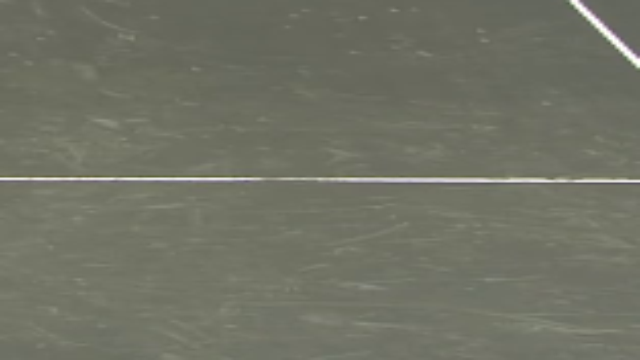

In [297]:
dataset = ImageFolder(os.path.join(data_root,'data'))
img_or = tfs.RandomResizedCrop(size=(360, 640),scale=(0.3, 1.0),ratio = (0.8,1.5))(dataset[2028][0])

for i in range(500):
    img = tfs.RandomResizedCrop(size=(360, 640),scale=(0.3, 1.0),ratio = (0.8,1.5))(dataset[2028][0])
    if (np.array(img) != np.array(img_or)).any():
        print(i)
        break
else:
    print("all same")
    
img

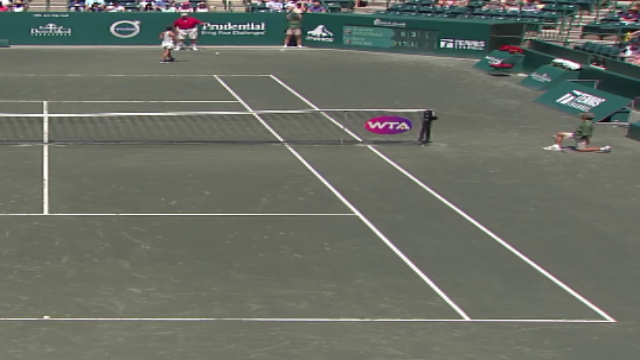

In [261]:
img_or

tensor([[[1.0703, 0.8438, 0.7109,  ..., 0.0391, 0.0391, 0.0312],
         [0.8906, 0.7891, 0.5703,  ..., 0.0547, 0.0469, 0.0312],
         [0.4766, 0.5234, 0.4766,  ..., 0.0703, 0.0547, 0.0391],
         ...,
         [0.7031, 0.7109, 0.7188,  ..., 0.1094, 0.0859, 0.0781],
         [0.6562, 0.6484, 0.6719,  ..., 0.1016, 0.0781, 0.0625],
         [0.6719, 0.6484, 0.6797,  ..., 0.0938, 0.0703, 0.0625]]])